# Predicting Fuel Efficiency of Vehicles

In this series, we'd be going from data collection to deploying the Machine Learning model:

1. **Data Collection** - we are using the classic [Auto MPG dataset](http://archive.ics.uci.edu/ml/datasets/Auto+MPG) from UCI ML Repository.
2. **Define Problem Statement** - We'll frame the problem based on the dataset description and initial exploration.
3. **EDA** - Carry our exploratory analysis to figure out the important features
4. **Data Preparation** - Using step 4, create a pipeline of tasks to transform the data to be loaded into our ML models.
5. **Selecting and Training ML models** - Training a few models to evaluate their predictions using cross-validation.
6. **Hyperparameter Tuning** - Fine tune the hyperparameters for the models that showed promising results.
7. **Deploy the Model using a web service** - Using **Flask web framework** to deploy our trained model on **Heroku**

### Step 1: Collecting Data from UCI ML repository

In [821]:
##importing a few general use case libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [822]:
# reading the .data file using pandas

cols = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(r'C:\Users\asusasus\Downloads\auto-mpg.data', names=cols, na_values = "?",
                comment = '\t',
                sep= " ",
                skipinitialspace=True)

data = df.copy()

In [823]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Problem Statement:

The data contains MPG variable which is continuous data and tells us about the efficiency of fuel consumption of a vehicle in 70s and 80s.

Our aim here is to **predict the MPG value for a vehicle** given we have other attributes of that vehicle.

### Step 3: Exploratory Data Analysis

1. Check for Data type of columns
2. Check for null values.
3. Check for outliers
4. Look for the category distribution in categorical columns
5. Plot for correlation


In [824]:
##checking the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [825]:
##summary statistics of quantitative variables
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [827]:
##checking for all the null values
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [835]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(data):
  vif = pd.DataFrame()
  vif['variables'] = data.columns
  vif['vif_score']= [variance_inflation_factor(data.values,i ) for i in range(data.shape[1])]
  return (vif) 



<AxesSubplot: >

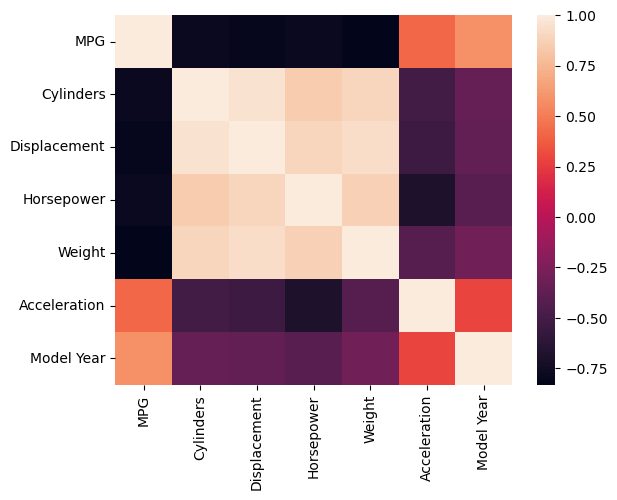

In [855]:
sns.heatmap(data.corr())

<AxesSubplot: xlabel='Horsepower'>

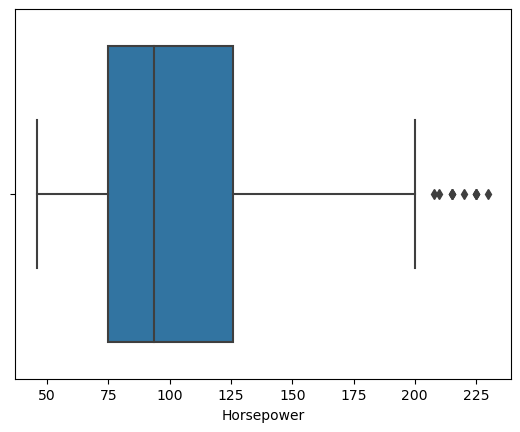

In [836]:
sns.boxplot(x=data['Horsepower'])

In [837]:
#pairplots to get an intuition of potential correlations
sns.pairplot(data[["MPG", "Cylinders", "Displacement", "Weight", "Horsepower"]], diag_kind="kde")


In [838]:
def preprocess_origin_cols(df):
    df["Origin"] = df["Origin"].map({1: "India", 2: "USA", 3: "Germany"})
    return df
data= preprocess_origin_cols(data)
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,India
1,15.0,8,350.0,165.0,3693.0,11.5,70,India
2,18.0,8,318.0,150.0,3436.0,11.0,70,India
3,16.0,8,304.0,150.0,3433.0,12.0,70,India
4,17.0,8,302.0,140.0,3449.0,10.5,70,India


In [839]:
x = data.drop(['MPG'],axis=1)
y = data['MPG']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [840]:
x_train.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
3,8,304.0,150.0,3433.0,12.0,70,India
18,4,97.0,88.0,2130.0,14.5,70,Germany
376,4,91.0,68.0,2025.0,18.2,82,Germany
248,4,91.0,60.0,1800.0,16.4,78,Germany
177,4,115.0,95.0,2694.0,15.0,75,USA


In [841]:
print(x.shape, y.shape)

# determine categorical and numerical features
numerical_ix = x.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = x.select_dtypes(include=['object', 'bool']).columns

(398, 7) (398,)


In [842]:
# imputation transformer
trf1 = ColumnTransformer([('impute_Horsepower',SimpleImputer(),[2])],remainder='passthrough')

In [843]:
# one hot encoding
trf2 = ColumnTransformer([
    ('ohe_Origin',OneHotEncoder(sparse=False,handle_unknown='ignore'),[6])],remainder='passthrough')

In [844]:
# Scaling
trf3 = ColumnTransformer([
   ('scale',MinMaxScaler(),slice(0,9))])

In [845]:
#Feature selection
trf4 = SelectKBest(score_func=f_regression,k=5)

In [846]:
#train the model
trf5 = RandomForestRegressor()

In [847]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf4',trf4),
    ('trf5',trf5)
])

In [848]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_Horsepower',
                                                  SimpleImputer(), [2])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_Origin',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 9, None))])),
                ('trf4',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001C8E5F2A4C0>)),
                ('trf5', RandomForestRegressor())])

In [849]:
pipe.named_steps['trf1'].transformers_[0][1].statistics_

array([103.28434505])

In [850]:
from sklearn import set_config
set_config(display = 'diagram')

In [851]:
y_pred = pipe.predict(x_test)

In [852]:
from sklearn.metrics import r2_score,mean_squared_error

In [853]:
print('r2: ',r2_score(y_test,y_pred))
print('mse: ',mean_squared_error(y_test,y_pred))

r2:  0.9044093043163189
mse:  5.139571762500005


In [809]:
#hyperparameter tuning GridSearchCV

param_grid = {
    'trf5__bootstrap': [True],
    'trf5__max_depth': range(20,140,20),
    'trf5__max_features': [2, 3],
    'trf5__min_samples_leaf': [3, 4, 5],
    'trf5__min_samples_split': [8, 10, 12],
    'trf5__n_estimators': [50,100, 200, 300]
}


In [810]:
grid = GridSearchCV(pipe,param_grid, cv = 5,scoring = 'r2',n_jobs=-1,verbose= True)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('impute_Horsepower',
                                                                         SimpleImputer(),
                                                                         [2])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe_Origin',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [6])])),
                                       ('trf3',
                                        ColumnTransformer(transformers=[('scale',
                                                                         MinMaxScal...
                                        SelectKBest(k=5,
                                                    score_func=<function f_regression at 0x000001C8E5F2A4C0>)),
                                       ('trf5', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'trf5__bootstrap': [True],
                         'trf5__max_depth': range(20, 140, 20),
                         'trf5__max_features': [2, 3],
                         'trf5__min_samples_leaf': [3, 4, 5],
                         'trf5__min_samples_split': [8, 10, 12],
                         'trf5__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=True)

In [811]:
grid.best_estimator_

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_Horsepower',
                                                  SimpleImputer(), [2])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_Origin',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 9, None))])),
                ('trf4',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001C8E5F2A4C0>)),
                ('trf5',
                 RandomForestRegressor(max_depth=60, max_features=2,
                                       min_samples_leaf=3,
                                       min_samples_split=8))])

In [812]:
grid.best_score_

0.8179755041959644

In [814]:
trf5 =RandomForestRegressor(max_depth=60, max_features=2, min_samples_leaf=3, min_samples_split=8)

In [815]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf4',trf4),
    ('trf5',trf5)
])

In [816]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_Horsepower',
                                                  SimpleImputer(), [2])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_Origin',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 9, None))])),
                ('trf4',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x000001C8E5F2A4C0>)),
                ('trf5',
                 RandomForestRegressor(max_depth=60, max_features=2,
                                       min_samples_leaf=3,
                                       min_samples_split=8))])

In [817]:
y_pred = pipe.predict(x_test)
print('r2: ',r2_score(y_test,y_pred))
print('mse: ',mean_squared_error(y_test,y_pred))

r2:  0.9002109185813423
mse:  5.365304032960431


In [818]:
test_input2 = np.array([8,304.0,150.0,3433.0,12.0,70,'India']).reshape(1,7)

pipe.predict(test_input2)

array([15.71263435])

In [856]:
import pickle
pickle.dump(pipe, open('pipe.pkl','wb'))

In [858]:
pipe = pickle.load(open('pipe.pkl','rb'))
pipe.predict(test_input2)

array([16.455])